<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_05_pytorch_sklearn_pipeline_04_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baseline Model

In [53]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

optimal_threshold = 0.8000141978263855

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > optimal_threshold).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimpleNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
y_pred_baseline = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(),y_pred_baseline))


              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      4673
         1.0       0.59      0.45      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.80      0.81      0.80      6000



## Categorical Data Types Model

Changing data types such as `sex`, `education`, and `marriage` from numeric to categorical can be beneficial for several reasons:

1. **Representation of True Nature**: These variables represent discrete categories rather than continuous values. Treating them as categorical ensures the model interprets them correctly.

2. **Avoiding Misinterpretation**: Numeric encoding might imply a natural order or distance between values, which may not exist (e.g., `sex` with values 1 and 2). Using categorical encoding avoids this misinterpretation.

3. **Improved Model Performance**: Many machine learning algorithms can leverage categorical encodings more effectively. For instance, decision trees and their ensembles (like random forests) can make better splits on categorical data.

4. **Handling Missing Values**: Categorical variables can be imputed with a specific value like 'missing' without implying any numerical meaning, whereas imputing numeric variables typically involves statistical measures like mean or median.

5. **One-Hot Encoding**: Categorical data can be one-hot encoded, which creates binary columns for each category. This can help models learn relationships more effectively compared to single numeric columns.

By converting these columns to categorical, we ensure they are processed in a way that aligns with their nature and can lead to better model interpretability and performance.

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Convert specific numeric columns to categorical
categorical_columns = ['sex', 'education', 'marriage']
df[categorical_columns] = df[categorical_columns].astype('category')

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

optimal_threshold = 0.8000141978263855

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > optimal_threshold).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimpleNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
y_pred_categorical = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), y_pred_categorical))


              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      4673
         1.0       0.59      0.44      0.50      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.67      0.69      6000
weighted avg       0.79      0.81      0.80      6000



#### Plotting Function to Compare Performance

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="viridis"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()


<Figure size 1200x800 with 0 Axes>

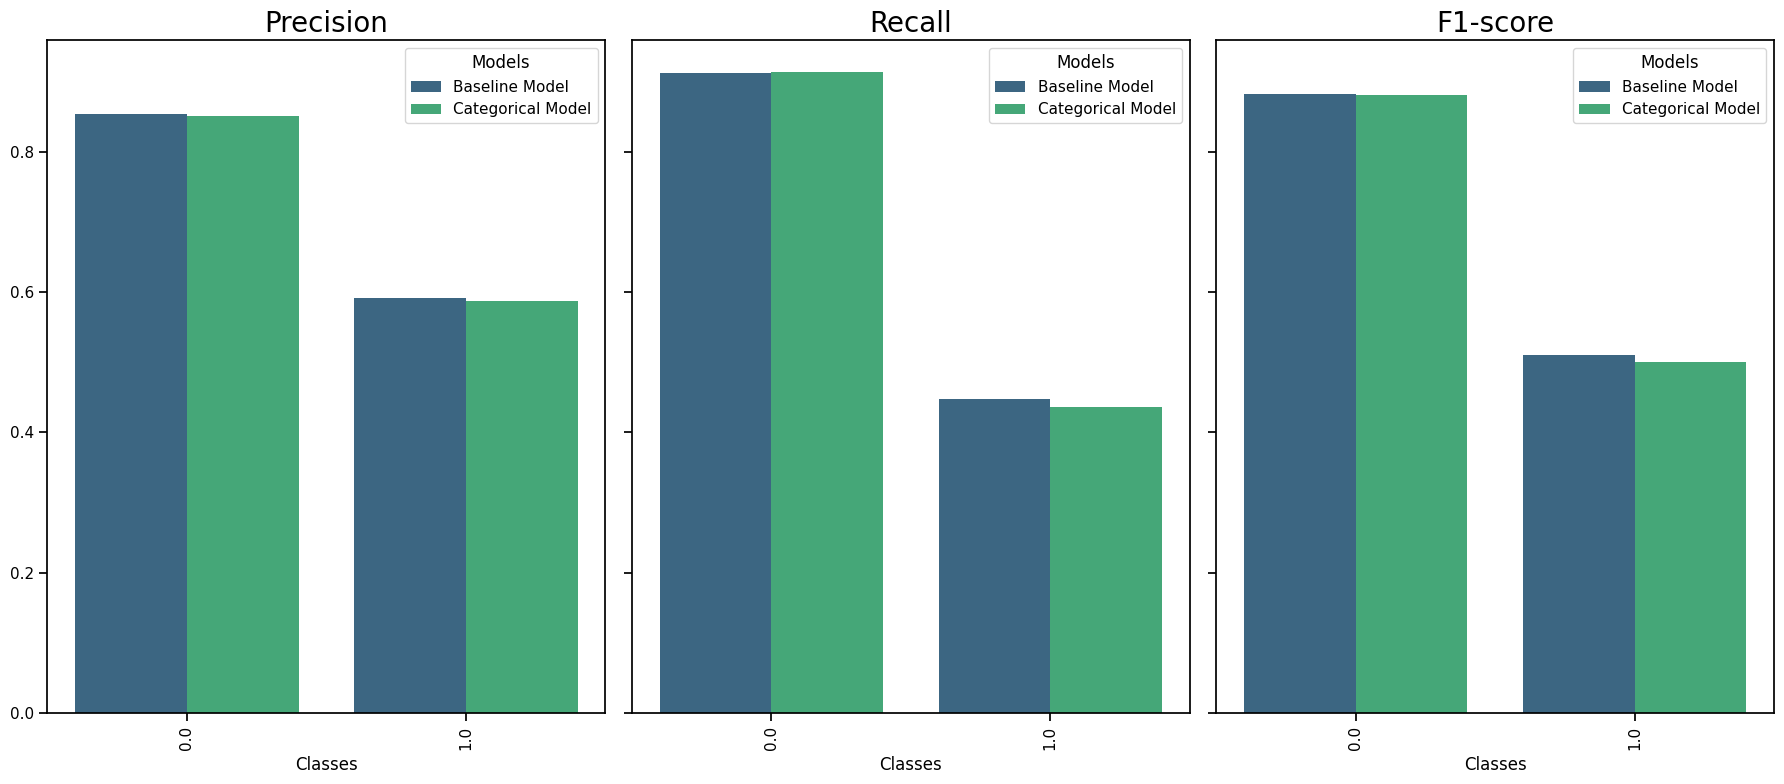

In [55]:
# plot comparisons
y_trues = [y_test_tensor.numpy(), y_test_tensor.numpy()]  # Replace with actual test sets
y_preds = [y_pred_baseline, y_pred_categorical]  # Replace with actual predictions
model_names = ['Baseline Model', 'Categorical Model']  # Replace with actual model names
plot_multiple_classification_reports(y_trues, y_preds, model_names)

## Feature Selection Methods

1. **Univariate Feature Selection**: Using statistical tests to select features.
2. **Recursive Feature Elimination (RFE)**: Iteratively removing the least important features.
3. **Principal Component Analysis (PCA)**: Reducing dimensionality by transforming features into a new set of variables.
4. **Feature Importance from Models**: Using models that provide feature importance scores, such as Random Forests or Gradient Boosting.

Your outline for feature selection looks solid and covers a variety of methods to assess and select important features. Here's a brief explanation of each method you've listed, and how they fit into the feature selection process:

1. **Univariate Feature Selection**:
   - Uses statistical tests to select the features that have the strongest relationship with the target variable.
   - Common techniques include chi-square tests, ANOVA F-tests, and mutual information.

2. **Recursive Feature Elimination (RFE)**:
   - Iteratively removes the least important features based on a model's coefficients or feature importance scores.
   - Continues until the specified number of features is reached or until no further improvement is observed.
   - Works well with linear models, decision trees, and any model that can provide feature importance.

3. **Principal Component Analysis (PCA)**:
   - A dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called principal components.
   - The principal components are ordered by the amount of variance they explain, and you can select the top components to reduce the number of features while retaining most of the variance in the data.

4. **Feature Importance from Models**:
   - Utilizes models that can provide feature importance scores, such as Random Forests, Gradient Boosting, and XGBoost.
   - Features are ranked based on their importance scores, and the top features are selected.





## Univariate Feature Selection Function (ANOVA)

We'll start with Univariate Feature Selection using ANOVA F-value and then move on to the other methods.

### Summary of ANOVA (Analysis of Variance)

**ANOVA (Analysis of Variance)** is a statistical technique used to determine if there are any statistically significant differences between the means of three or more independent (unrelated) groups. It essentially helps to test hypotheses about the means of different groups and is widely used in feature selection for machine learning.

### What ANOVA Does

1. **Hypothesis Testing**:
    - **Null Hypothesis (\(H_0\))**: Assumes that the means of different groups are equal.
    - **Alternative Hypothesis (\(H_1\))**: Assumes that at least one group's mean is different from the others.

2. **F-Statistic**:
    - ANOVA calculates an F-statistic, which is the ratio of the variance between the group means to the variance within the groups.
    - A higher F-statistic indicates that the group means are more spread out, suggesting a significant difference between groups.

3. **P-Value**:
    - The p-value associated with the F-statistic helps determine whether to reject the null hypothesis.
    - A low p-value (typically < 0.05) indicates that there is a significant difference between the group means.

### Types of ANOVA

1. **One-Way ANOVA**:
    - Used when comparing means of more than two groups based on one independent variable.
    
2. **Two-Way ANOVA**:
    - Used when comparing means with two independent variables. It can also evaluate the interaction between these variables.

### Application in Feature Selection

In the context of feature selection for machine learning, ANOVA can be used to select features that have the strongest relationship with the target variable:

1. **Univariate Feature Selection**:
    - ANOVA is used as a scoring function in techniques like `SelectKBest` to select the top features.
    - Features are scored based on their F-statistic with respect to the target variable.

### Example in Python with `SelectKBest`

Here's a brief example of how ANOVA is used in feature selection with `SelectKBest`:

```python
from sklearn.feature_selection import SelectKBest, f_classif

# Apply SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get the selected feature indices
selected_features = selector.get_support(indices=True)
```

In this example:
- **`SelectKBest`**: Selects the top k features based on their ANOVA F-statistic.
- **`f_classif`**: Function that calculates the ANOVA F-statistic for classification tasks.

### Conclusion

ANOVA is a powerful statistical tool used to test differences between group means and is particularly useful in feature selection for identifying features that are most significant in predicting the target variable. By using ANOVA, you can improve the performance of your machine learning models by selecting the most relevant features.

### Iterating Through `k` Values for Feature Selection

The idea behind iterating through `k` values for feature selection is to systematically determine the optimal number of features that maximize the performance of your machine learning model. Here's a step-by-step explanation of the concept:

1. **Goal**:
    - Identify the number of features that provide the best model performance.
    - Avoid selecting too few or too many features, which can lead to underfitting or overfitting, respectively.

2. **Method**:
    - **Range of `k` Values**: Define a range of values for `k`, where `k` is the number of top features to select. This range typically spans from 1 to the total number of features in the dataset.
    - **Model Evaluation for Each `k`**: For each value of `k`:
        - **Feature Selection**: Use a feature selection method (e.g., ANOVA with `SelectKBest`) to select the top `k` features.
        - **Model Training**: Train the machine learning model using only the selected features.
        - **Performance Measurement**: Evaluate the model's performance using a chosen metric, such as accuracy, precision, recall, or F1-score.

3. **Performance Comparison**:
    - **Collect Performance Metrics**: For each value of `k`, record the model's performance metrics.
    - **Plot/Analyze Results**: Plot the performance metrics against the values of `k` to visualize how the number of selected features affects the model's performance.
    - **Select Optimal `k`**: Identify the value of `k` that results in the best model performance. This optimal `k` represents the ideal number of features to use.

4. **Benefits**:
    - **Systematic Approach**: Provides a systematic way to determine the best number of features without arbitrary selection.
    - **Performance Optimization**: Helps in finding the balance between having enough features to capture the necessary information and avoiding irrelevant or redundant features that could harm model performance.

### Summary of Steps

1. **Define `k` Range**: Decide the range of `k` values to test (e.g., from 1 to the total number of features).
2. **Select Features**: For each `k`, select the top `k` features using a feature selection method.
3. **Train and Evaluate**: Train the model on the selected features and evaluate its performance.
4. **Collect Metrics**: Record performance metrics for each `k`.
5. **Analyze Results**: Plot the metrics against `k` to find the optimal number of features that maximize performance.

By iterating through different values of `k`, this method allows you to empirically determine the most effective subset of features for your machine learning model, ensuring robust and optimized performance.

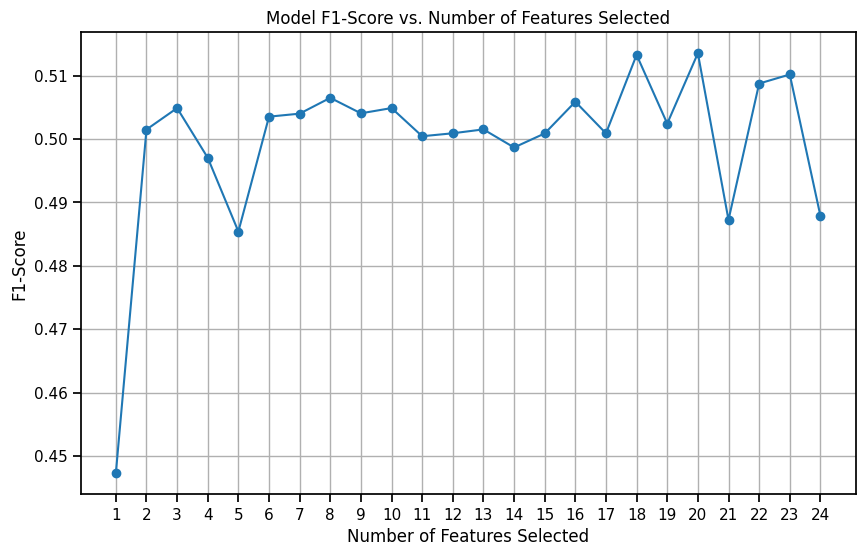

In [61]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import torch

# Function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test, k):
    # Create a pipeline with preprocessing and feature selection
    feature_selection_pipeline = SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k))
    ])

    # Fit and transform the training data
    X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
    X_test_selected = feature_selection_pipeline.transform(X_test)

    # Apply RandomUnderSampler to balance the training dataset
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Create an instance of SklearnSimpleNN with the adjusted weight
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

    # Fit the model
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

    # Predict on the test set with the optimal threshold
    y_pred = nn_estimator.predict(X_test_tensor.numpy())

    # Calculate F1-score
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1, classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)

# Range of values for k
k_values = range(1, X_train.shape[1] + 1)

# Store F1-score for each value of k
f1_scores = []
classification_reports = []

for k in k_values:
    f1, report = evaluate_model(X_train, y_train, X_test, y_test, k)
    f1_scores.append(f1)
    classification_reports.append(report)

# Plot the F1-scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.title('Model F1-Score vs. Number of Features Selected')
plt.xlabel('Number of Features Selected')
plt.ylabel('F1-Score')
plt.xticks(k_values)
plt.grid()
plt.show()


### Select K Best - Get Feature Names

Top 1 features: ['pay_0']
Top 2 features: ['pay_0' 'pay_2']
Top 3 features: ['pay_0' 'pay_2' 'pay_3']
Top 4 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4']
Top 5 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5']
Top 6 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6']
Top 7 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6']
Top 8 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1']
Top 9 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2']
Top 10 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt4']
Top 11 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt3' 'pay_amt4']
Top 12 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt3' 'pay_amt4' 'pay_amt6']
Top 13 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_a

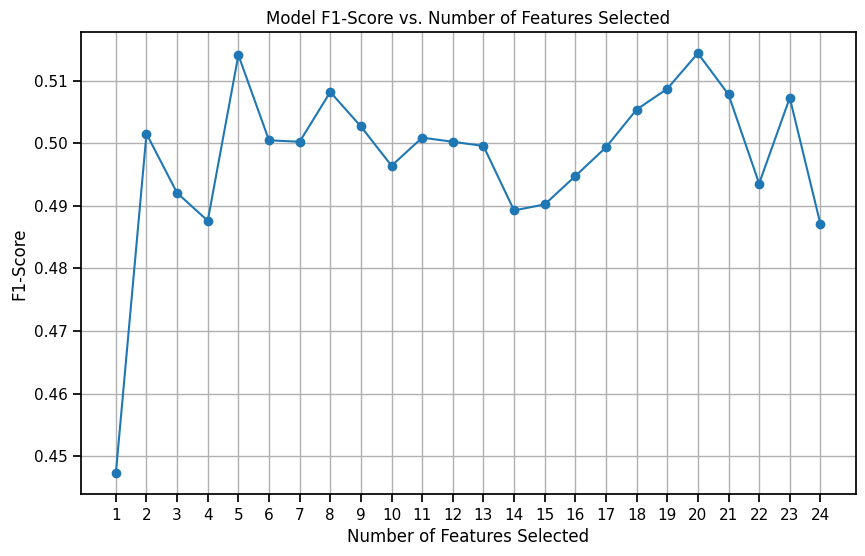

In [64]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to evaluate model performance and get selected features
def evaluate_model(X_train, y_train, X_test, y_test, k):
    # Create a pipeline with preprocessing and feature selection
    feature_selection_pipeline = SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k))
    ])

    # Fit and transform the training data
    X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
    X_test_selected = feature_selection_pipeline.transform(X_test)

    # Get the selected feature indices
    selector = feature_selection_pipeline.named_steps['feature_selection']
    selected_feature_indices = selector.get_support(indices=True)

    # Get feature names after preprocessing
    preprocessor_transformer = feature_selection_pipeline.named_steps['preprocessor']
    preprocessed_feature_names = np.array(X_train.columns)

    # If preprocessing includes transformations like OneHotEncoding, get the actual feature names
    if hasattr(preprocessor_transformer, 'transformers_'):
        feature_names = []
        for name, transformer, columns in preprocessor_transformer.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
        preprocessed_feature_names = np.array(feature_names)

    selected_feature_names = preprocessed_feature_names[selected_feature_indices]

    # Apply RandomUnderSampler to balance the training dataset
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Create an instance of SklearnSimpleNN with the adjusted weight
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

    # Fit the model
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

    # Predict on the test set with the optimal threshold
    y_pred = nn_estimator.predict(X_test_tensor.numpy())

    # Calculate F1-score
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1, classification_report(y_test_tensor.numpy(), y_pred, output_dict=True), selected_feature_names

# Range of values for k
k_values = range(1, X_train.shape[1] + 1)

# Store F1-score and selected features for each value of k
f1_scores = []
classification_reports = []
selected_features_list = []

for k in k_values:
    f1, report, selected_features = evaluate_model(X_train, y_train, X_test, y_test, k)
    f1_scores.append(f1)
    classification_reports.append(report)
    selected_features_list.append(selected_features)
    print(f"Top {k} features: {selected_features}")

# Plot the F1-scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.title('Model F1-Score vs. Number of Features Selected')
plt.xlabel('Number of Features Selected')
plt.ylabel('F1-Score')
plt.xticks(k_values)
plt.grid()
plt.show()


Seeing different F1 scores on reruns can be normal, especially in the context of machine learning, due to various sources of randomness in your pipeline. Here are some common reasons for the variability:

1. **Random Initialization of Neural Networks**:
    - The weights of the neural network are initialized randomly. Different initializations can lead to different training outcomes.
  
2. **Random Sampling in Data Splitting**:
    - The train-test split or cross-validation process may involve randomness unless a fixed random seed is used.
  
3. **Random Undersampling**:
    - The `RandomUnderSampler` introduces randomness in how the majority class samples are undersampled.

### Ensuring Reproducibility

To minimize variability and make results more reproducible, you can set random seeds for all operations that involve randomness. Here's how you can modify your code to include random seeds:

1. **Set Random Seed for PyTorch**:
    ```python
    import torch
    import numpy as np
    import random

    def set_seed(seed):
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Example usage
    set_seed(42)
    ```

2. **Set Random State in Scikit-Learn**:
    - Ensure the `train_test_split` and `RandomUnderSampler` use a fixed `random_state`.

### Explanation of Changes

1. **Set Seed for Reproducibility**:
    - The `set_seed` function sets the seed for `numpy`, `random`, and `torch` to ensure reproducibility across runs.
    - The `random_state` parameter is set in `RandomUnderSampler` to ensure consistent sampling.

By setting random seeds, you can minimize the variability in your results and achieve more consistent F1 scores across different runs.



Top 1 features: ['pay_0']
Top 2 features: ['pay_0' 'pay_2']
Top 3 features: ['pay_0' 'pay_2' 'pay_3']
Top 4 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4']
Top 5 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5']
Top 6 features: ['pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6']
Top 7 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6']
Top 8 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1']
Top 9 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2']
Top 10 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt4']
Top 11 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt3' 'pay_amt4']
Top 12 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_amt1'
 'pay_amt2' 'pay_amt3' 'pay_amt4' 'pay_amt6']
Top 13 features: ['limit_bal' 'pay_0' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'pay_a

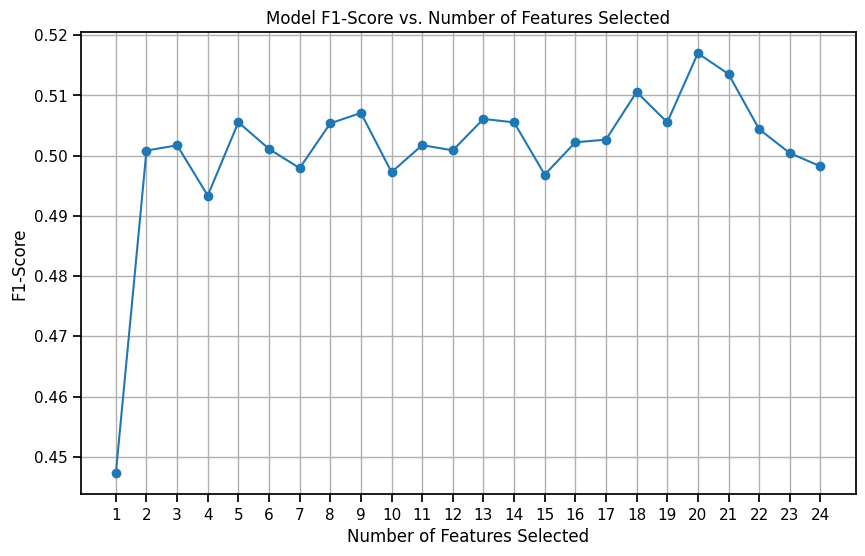

In [69]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Set random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

# Function to evaluate model performance and get selected features
def evaluate_model(X_train, y_train, X_test, y_test, k):
    # Create a pipeline with preprocessing and feature selection
    feature_selection_pipeline = SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k))
    ])

    # Fit and transform the training data
    X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
    X_test_selected = feature_selection_pipeline.transform(X_test)

    # Get the selected feature indices
    selector = feature_selection_pipeline.named_steps['feature_selection']
    selected_feature_indices = selector.get_support(indices=True)

    # Get feature names after preprocessing
    preprocessor_transformer = feature_selection_pipeline.named_steps['preprocessor']
    preprocessed_feature_names = np.array(X_train.columns)

    # If preprocessing includes transformations like OneHotEncoding, get the actual feature names
    if hasattr(preprocessor_transformer, 'transformers_'):
        feature_names = []
        for name, transformer, columns in preprocessor_transformer.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
        preprocessed_feature_names = np.array(feature_names)

    selected_feature_names = preprocessed_feature_names[selected_feature_indices]

    # Apply RandomUnderSampler to balance the training dataset
    undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Create an instance of SklearnSimpleNN with the adjusted weight
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

    # Fit the model
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

    # Predict on the test set with the optimal threshold
    y_pred = nn_estimator.predict(X_test_tensor.numpy())

    # Calculate F1-score
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1, classification_report(y_test_tensor.numpy(), y_pred, output_dict=True), selected_feature_names

# Range of values for k
k_values = range(1, X_train.shape[1] + 1)

# Store F1-score and selected features for each value of k
f1_scores = []
classification_reports = []
selected_features_list = []

for k in k_values:
    f1, report, selected_features = evaluate_model(X_train, y_train, X_test, y_test, k)
    f1_scores.append(f1)
    classification_reports.append(report)
    selected_features_list.append(selected_features)
    print(f"Top {k} features: {selected_features}")

# Plot the F1-scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.title('Model F1-Score vs. Number of Features Selected')
plt.xlabel('Number of Features Selected')
plt.ylabel('F1-Score')
plt.xticks(k_values)
plt.grid()
plt.show()

### Select K Best Model with Optimal K Value

In [67]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
import torch
from sklearn.metrics import classification_report

k = 20  # Optimal k value

# Univariate Feature Selection Function
def univariate_feature_selection(X_train, y_train, k='all'):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_features = selector.get_support(indices=True)
    return X_train_selected, selected_features

# Create a new pipeline with preprocessing and feature selection
feature_selection_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=k))
])

# Fit and transform the training data
X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
X_test_selected = feature_selection_pipeline.transform(X_test)

# Apply RandomUnderSampler to balance the training dataset
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create an instance of SklearnSimpleNN with the adjusted weight
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
y_pred_anova = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), y_pred_anova))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      4673
         1.0       0.59      0.46      0.52      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.80      0.81      0.80      6000



#### Model Comparison Plot

<Figure size 1200x800 with 0 Axes>

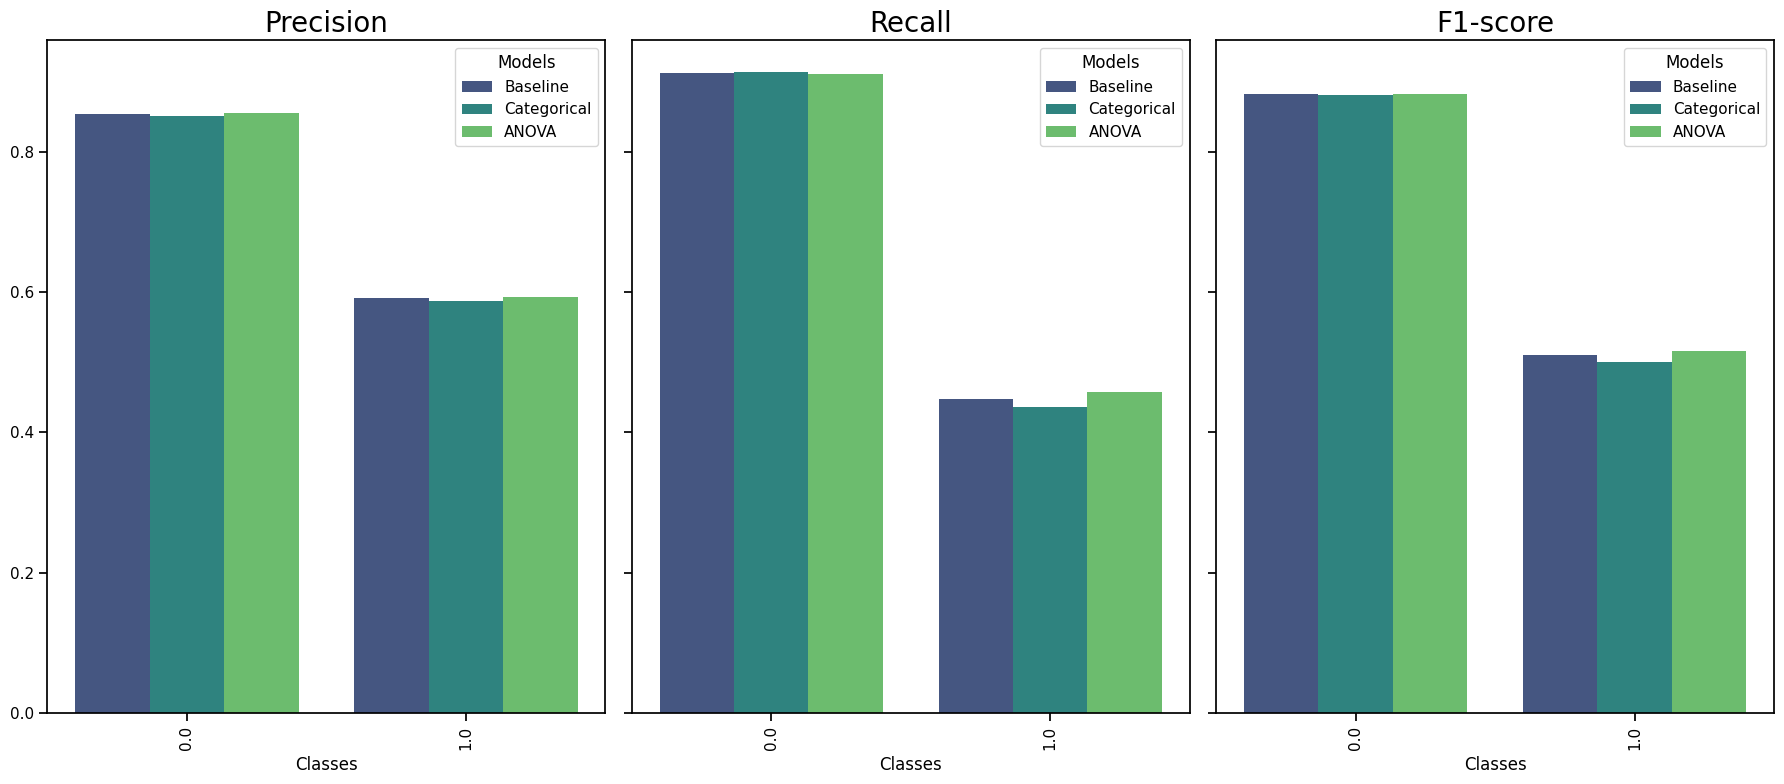

In [68]:
# plot comparisons
y_trues = [y_test_tensor.numpy(), y_test_tensor.numpy(), y_test_tensor.numpy()]
y_preds = [y_pred_baseline, y_pred_categorical, y_pred_anova]
model_names = ['Baseline', 'Categorical', 'ANOVA']
plot_multiple_classification_reports(y_trues, y_preds, model_names)

### Relationship Between Feature Selection and Model Selection

Feature selection and model selection are interconnected processes in machine learning, each influencing the other. Here are some key points that highlight their relationship:

1. **Model Sensitivity to Features**:
    - Different models can have varying sensitivities to the input features. For instance, linear models (like logistic regression) may perform well with a small set of highly relevant features, while non-linear models (like random forests and neural networks) can often handle a larger set of features, capturing complex interactions.

2. **Feature Selection Techniques**:
    - The choice of feature selection technique can be influenced by the type of model you plan to use. For example, univariate methods like ANOVA or mutual information are model-agnostic, while methods like Recursive Feature Elimination (RFE) or model-based selection (using feature importances from tree-based models) are model-specific.

3. **Performance and Feature Sets**:
    - Different models may achieve similar performance using different sets of features because of their inherent ability to capture patterns in the data. For example, a decision tree might rely on a specific set of features that are optimal for its splitting criteria, whereas a neural network might learn to combine features in a non-linear manner, allowing it to perform well with a different set.

4. **Redundancy and Interaction**:
    - Feature selection methods might select features that are highly correlated (redundant) or those that interact in complex ways. The ability of a model to handle these aspects can affect which features are deemed important. For instance, tree-based models handle feature interactions naturally, while linear models do not.

5. **Model Complexity and Overfitting**:
    - Simple models may benefit from aggressive feature selection to avoid overfitting, while complex models like neural networks might require more features to generalize well. The feature selection process should balance the need for simplicity and the ability to capture the underlying data distribution.

### Different Models with Different Feature Sets

It's possible for different models to achieve similar performance using different sets of features. This can occur because:

1. **Model Architecture**:
    - Models like neural networks can learn complex, non-linear relationships and interactions between features, potentially making use of features that linear models might not find useful.

2. **Model Training Dynamics**:
    - Different models might find different features to be important based on how they learn from the data. For example, a random forest might find certain features important due to its ensemble nature, while a support vector machine might find different features useful for defining the decision boundary.

### Practical Example

To demonstrate, we can use Random Forest and Neural Network models to see how they perform with different sets of features selected using feature importances from Random Forest and ANOVA.

### Summary

- **Different Models, Different Features**: Different models can indeed perform similarly using different sets of features because each model has its own way of utilizing the data.
- **Interconnection of Feature and Model Selection**: Feature selection impacts model performance, and the effectiveness of selected features can vary depending on the model.
- **Using Simpler Models for Feature Selection**: Using simpler models like Random Forests for initial feature selection can help streamline the process, which can then be transferred to more complex models like Neural Networks for final evaluation.

By understanding and leveraging the relationship between feature selection and model selection, you can optimize your machine learning pipeline to achieve better performance and efficiency.



#### Feature Selection with Random Forest and ANOVA

Top 1 features (RF): Index(['pay_0'], dtype='object')
Top 2 features (RF): Index(['pay_0', 'pay_2'], dtype='object')
Top 3 features (RF): Index(['pay_0', 'pay_2', 'pay_3'], dtype='object')
Top 4 features (RF): Index(['pay_0', 'pay_2', 'pay_3', 'pay_4'], dtype='object')
Top 5 features (RF): Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5'], dtype='object')
Top 6 features (RF): Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')
Top 7 features (RF): Index(['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')
Top 8 features (RF): Index(['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'pay_amt1'],
      dtype='object')
Top 9 features (RF): Index(['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'pay_amt1', 'pay_amt2'],
      dtype='object')
Top 10 features (RF): Index(['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'pay_amt1', 'pay_amt2', 'pay_amt4'],
   

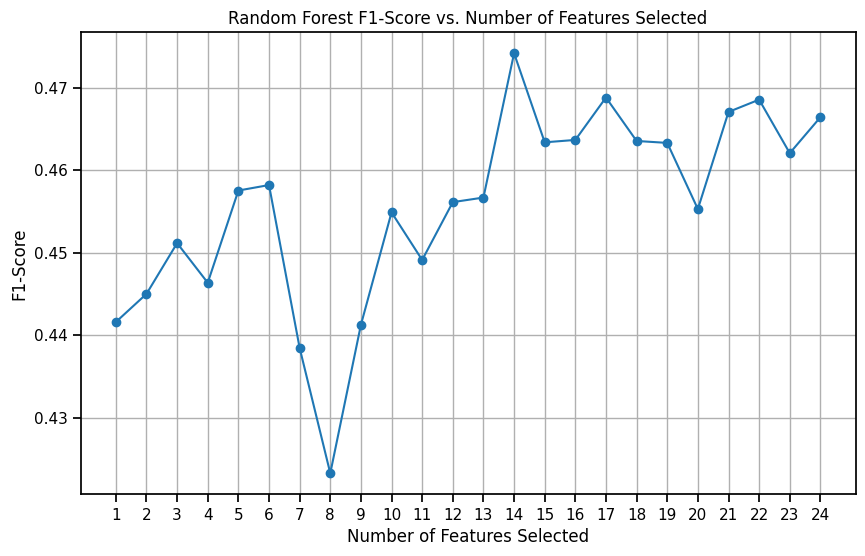

Neural Network F1-Score with features from RF: 0.3501742160278746


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Set random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Function to evaluate model performance and get selected features
def evaluate_model_rf(X_train, y_train, X_test, y_test, k):
    # Create a pipeline with preprocessing and feature selection
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get the selected feature indices
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_train.columns[selected_feature_indices]

    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_selected)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)
    return f1, classification_report(y_test, y_pred, output_dict=True), selected_feature_names

# Range of values for k
k_values = range(1, X_train.shape[1] + 1)

# Store F1-score and selected features for each value of k
f1_scores_rf = []
selected_features_list_rf = []

for k in k_values:
    f1, report, selected_features = evaluate_model_rf(X_train, y_train, X_test, y_test, k)
    f1_scores_rf.append(f1)
    selected_features_list_rf.append(selected_features)
    print(f"Top {k} features (RF): {selected_features}")

# Plot the F1-scores for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores_rf, marker='o')
plt.title('Random Forest F1-Score vs. Number of Features Selected')
plt.xlabel('Number of Features Selected')
plt.ylabel('F1-Score')
plt.xticks(k_values)
plt.grid()
plt.show()

# Assume optimal_k is the best k value found using Random Forest
optimal_k_rf = k_values[np.argmax(f1_scores_rf)]
optimal_features_rf = selected_features_list_rf[np.argmax(f1_scores_rf)]

# Filter training and test data with optimal features from RF
X_train_optimal_rf = X_train[optimal_features_rf]
X_test_optimal_rf = X_test[optimal_features_rf]

# Function to evaluate model performance with Neural Network
def evaluate_model_nn(X_train, y_train, X_test, y_test):
    # Apply RandomUnderSampler to balance the training dataset
    undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Create an instance of SklearnSimpleNN with the adjusted weight
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

    # Fit the model
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

    # Predict on the test set with the optimal threshold
    y_pred = nn_estimator.predict(X_test_tensor.numpy())

    # Calculate F1-score
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1, classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)

# Evaluate NN with features selected by RF
f1_nn_rf, report_nn_rf = evaluate_model_nn(X_train_optimal_rf, y_train, X_test_optimal_rf, y_test)
print(f"Neural Network F1-Score with features from RF: {f1_nn_rf}")

## Recursive Feature Elimination (RFE)

In [59]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import classification_report

# Recursive Feature Elimination Function
def recursive_feature_elimination(X_train, y_train, n_features_to_select=10):
    model = RandomForestClassifier()  # You can use any model that has a feature_importances_ or coef_ attribute
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    X_train_selected = rfe.fit_transform(X_train, y_train)
    selected_features = rfe.get_support(indices=True)
    return X_train_selected, selected_features

# Create a new pipeline with preprocessing and RFE
feature_selection_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(RandomForestClassifier(), n_features_to_select=10))  # Select top 10 features
])

# Fit and transform the training data
X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
X_test_selected = feature_selection_pipeline.transform(X_test)

# Apply RandomUnderSampler to balance the training dataset
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create an instance of SklearnSimpleNN with the adjusted weight
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
y_pred_rfe = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), y_pred_rfe))


              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88      4673
         1.0       0.61      0.39      0.48      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000



#### 3. Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA

# Example with PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

#### 4. Feature Importance from Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Example with RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importance
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Select top features
top_features = feature_importances.head(10)['feature']
X_top = X[top_features]

### Putting It All Together

You can iterate through these methods and compare the performance of your models using the `plot_multiple_classification_reports` function. Here's a basic example of how you might do this:

In [ ]:
# Define the different feature selection methods
feature_selection_methods = {
    'Univariate': SelectKBest(score_func=chi2, k=10),
    'RFE': RFE(RandomForestClassifier(), n_features_to_select=10),
    'PCA': PCA(n_components=10),
    'Feature Importance': RandomForestClassifier()
}

# Initialize lists to store results
y_trues, y_preds, model_names = [], [], []

for name, method in feature_selection_methods.items():
    if name == 'Feature Importance':
        model = method
        model.fit(X_train, y_train)
        importances = model.feature_importances_
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        top_features = feature_importances.head(10)['feature']
        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]
    else:
        X_train_selected = method.fit_transform(X_train, y_train)
        X_test_selected = method.transform(X_test)

    # Train and evaluate model with selected features
    model = RandomForestClassifier()  # Replace with your model
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Store results
    y_trues.append(y_test)
    y_preds.append(y_pred)
    model_names.append(name)

# Plot comparison
plot_multiple_classification_reports(y_trues, y_preds, model_names)
